# 04 - Calculate probabilites from the chi2 files

:::{warning}
Work in progress
:::

We now explain how to use a wrapper function to make all of the probability calculations necessary for a given star. We also show a wrapper function that will generate a PDF with useful diagnostic graphs. 

You will need to import the packages below:

In [1]:
import pyRaven as rav
import numpy as np

## 1. The calculation itself

The commands are relatively simple. 

1. We load up the <a href="../API/params.html#pyRaven.params.parameters">`Parameters`</a> object that was used to calculate the $\chi^2$ values on our grid of parameters.
2. We use <a href="../API/bayesobjects.html#pyRaven.BayesObjects.create_lnLH_odds_from_chi">`create_lnLH_odds_from_chi`</a> and <a href='../API/bayesobjects.html#pyRaven.BayesObjects.create_lnLH_pars_from_chi'>`create_lnlH_pars_from_chi`</a> functions to calculate the likelihoods from the $\chi^2$. 
    :::{note} 
    For the parameter estimation, `param['grid']['noise_grid']` must be defined in the <a href="../API/params.html#pyRaven.params.parameters">`Parameters`</a> object. We recommend a grid between 0.1 and 2.0 with 0.1 intervals. 
3. We use the <a href="../API/BayesObjects.html#pyRaven.BayesObjects.combine_obs">`combine_obs`</a> wrapper function to get all of the posterior probabilities. 
4. We use the <a href="../API/BayesObjects.html#pyRaven.BayesObjects.overview_plots">`overview_plots`</a> function to create a PDF that contains a summary of all of the relevant information. 

> TODO: Maybe wrap the LH calculation inside of the combine_obs wrapper, and pass it the chi folder, the datapacket and the param?

In [2]:
# Read in the param structure that was used to create the chi square data
# and the datapacket that was used. 
param = rav.params.read_parameters('ExampleOutput/03-ChiSquareCalcLoop/param_loop.json')
datapacket = rav.data.read_packet('ExampleOutput/01-DataSetup/ExamplePacket.h5')

/Users/vpetit/ASTRO/programme/pyRaven/pyRaven/BayesObjects.py:40: RuntimeWarning: divide by zero encountered in log
  ln_mar = np.log( np.sum(P_array, axis=axis) ) + norm


()

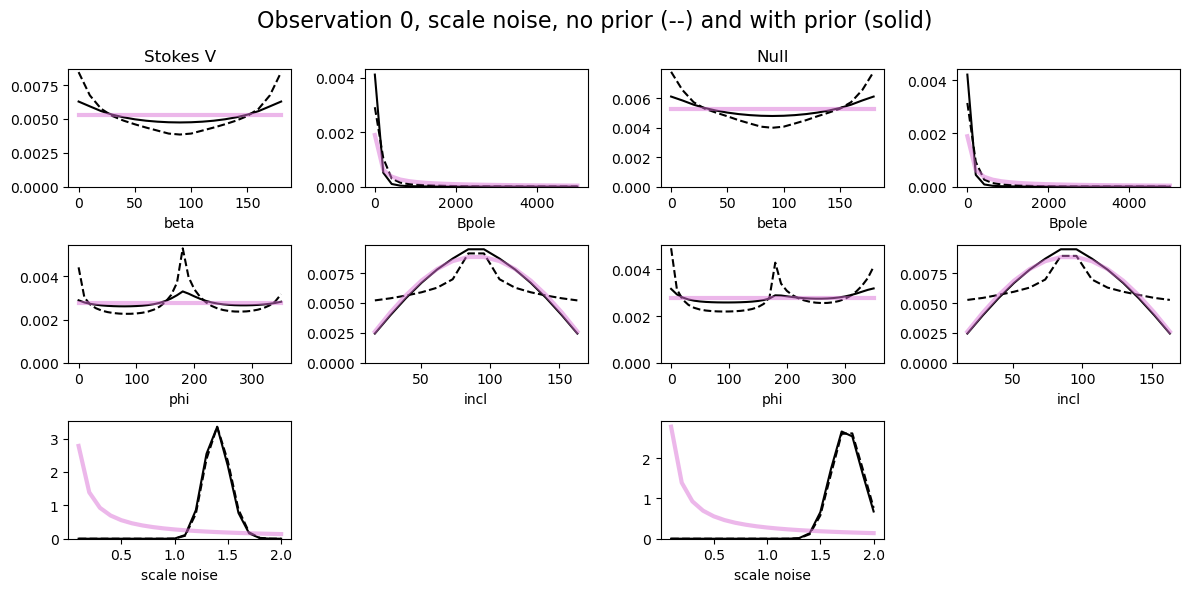

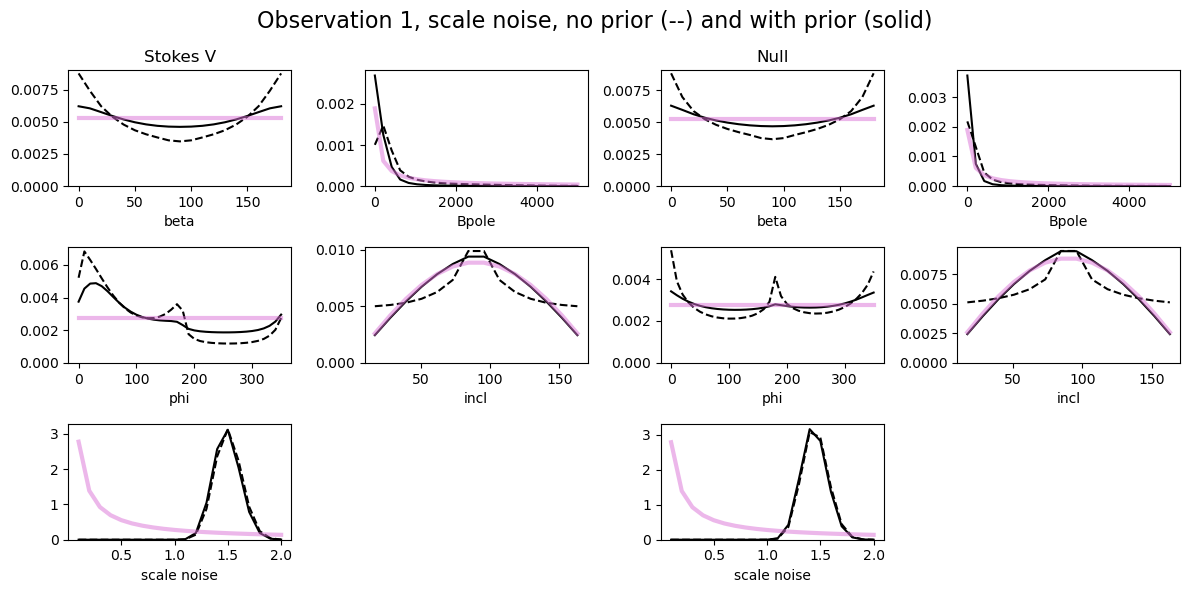

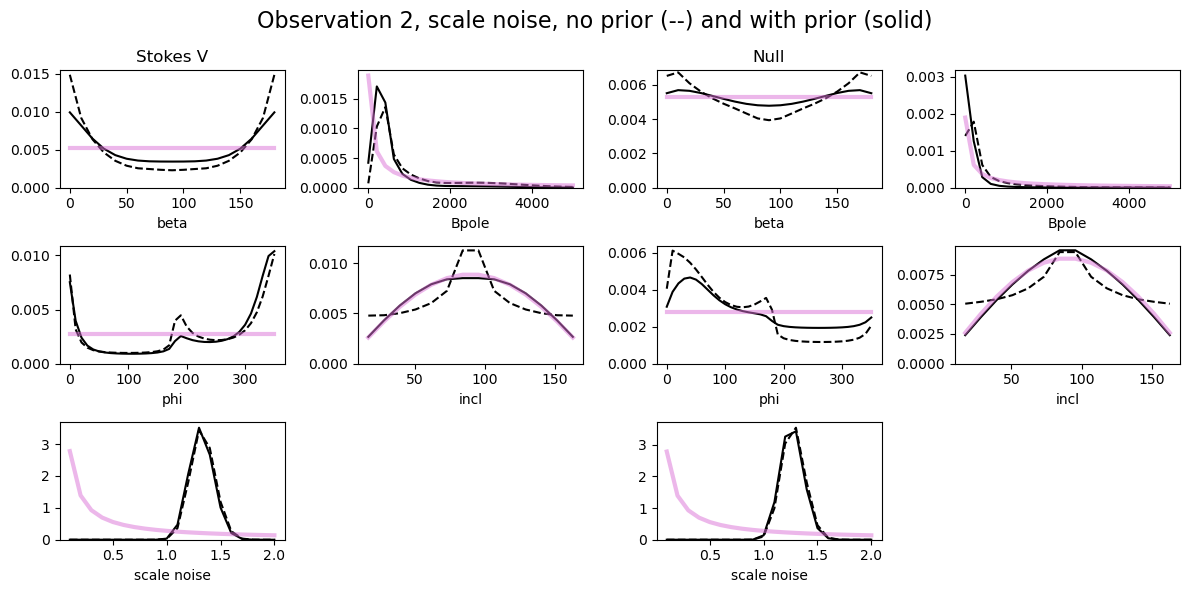

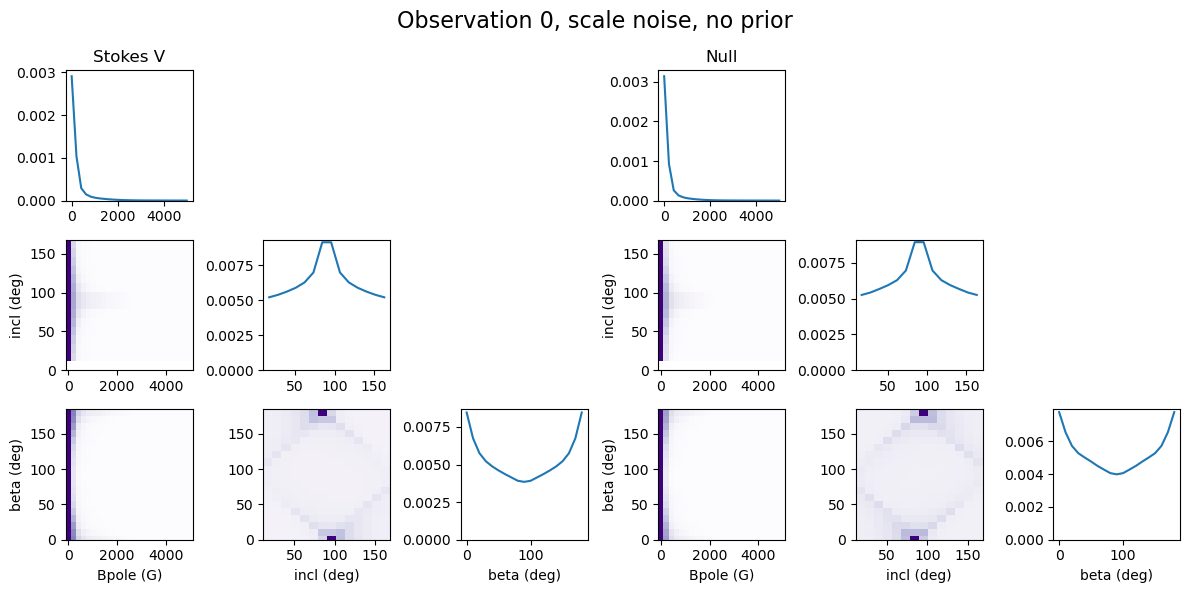

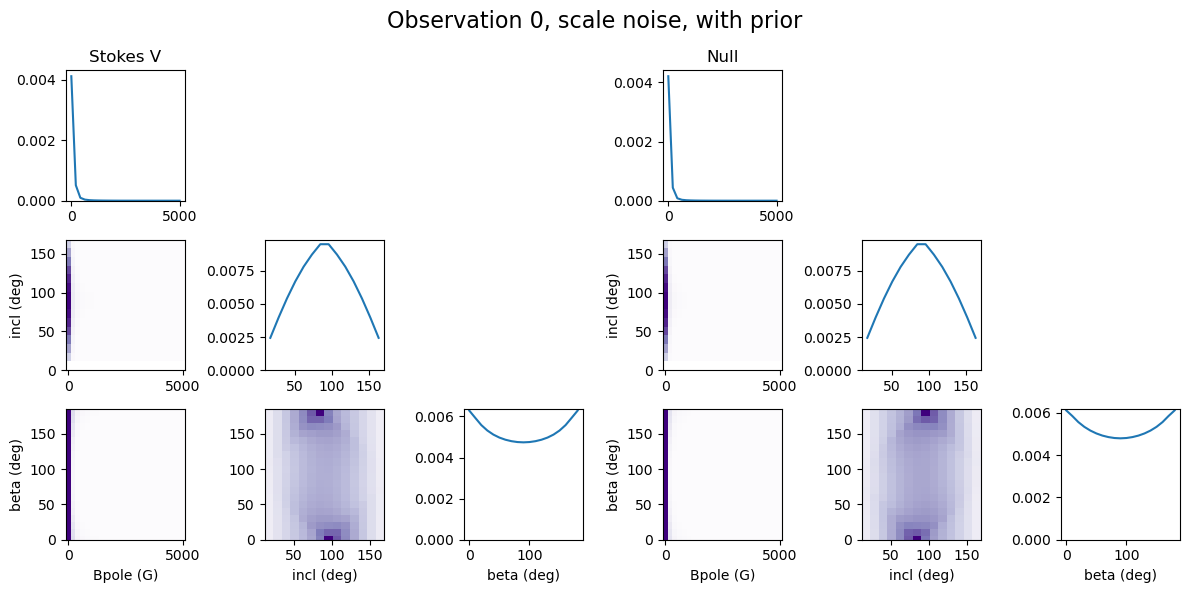

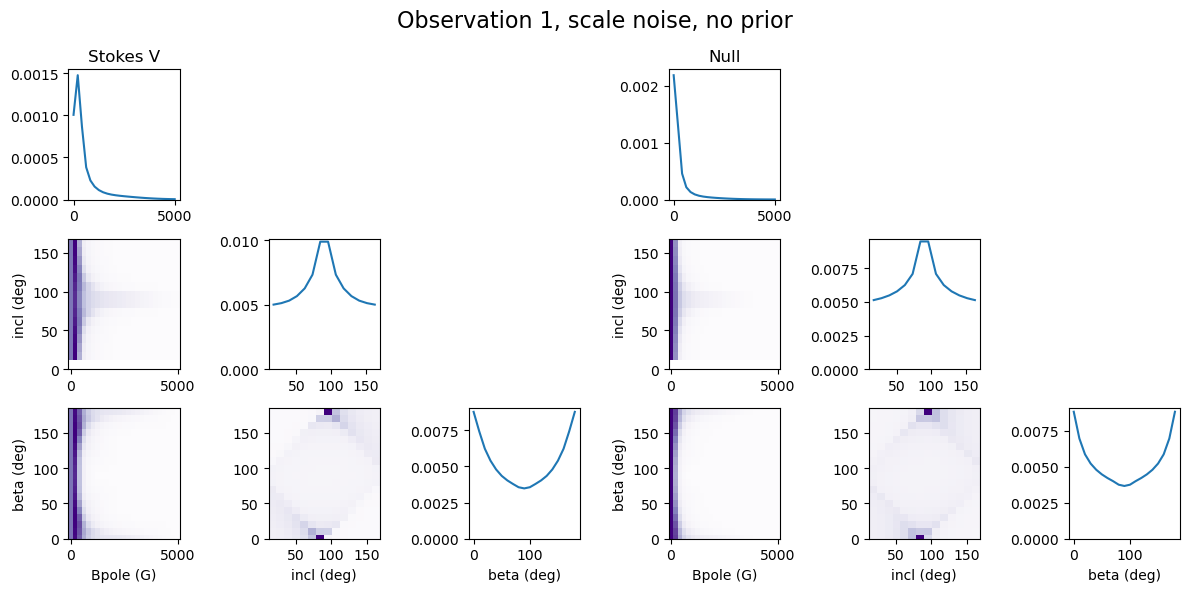

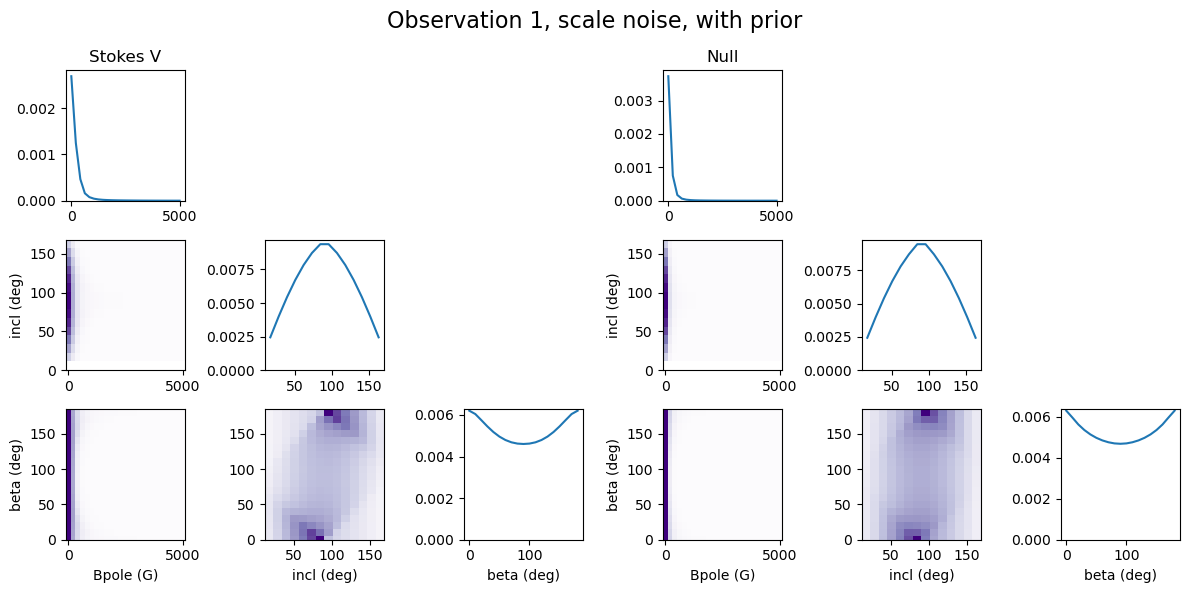

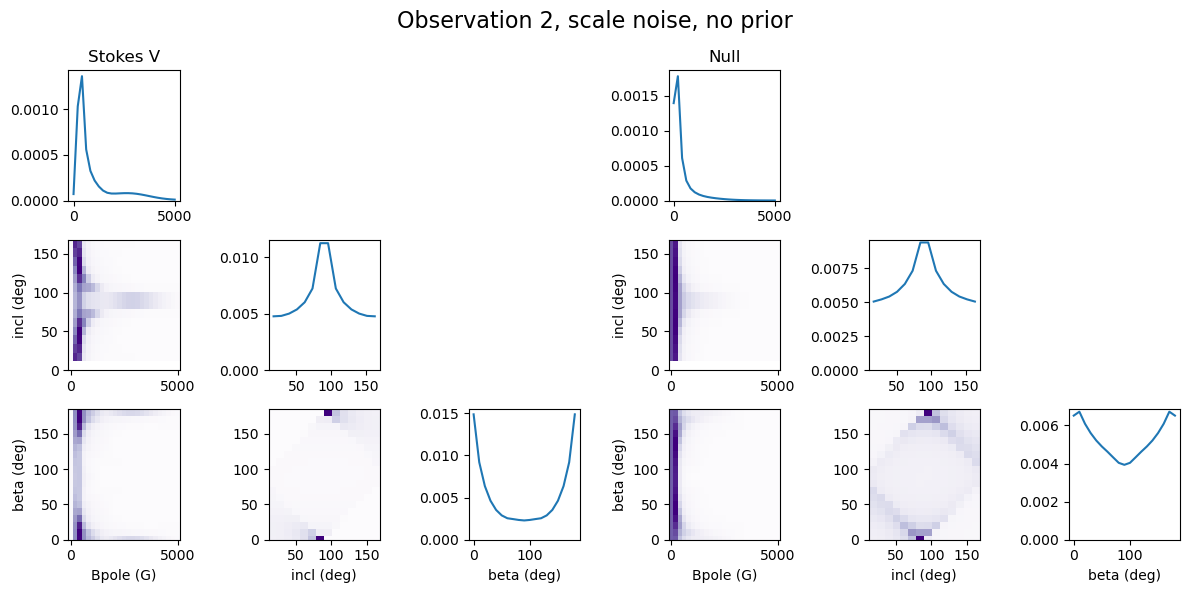

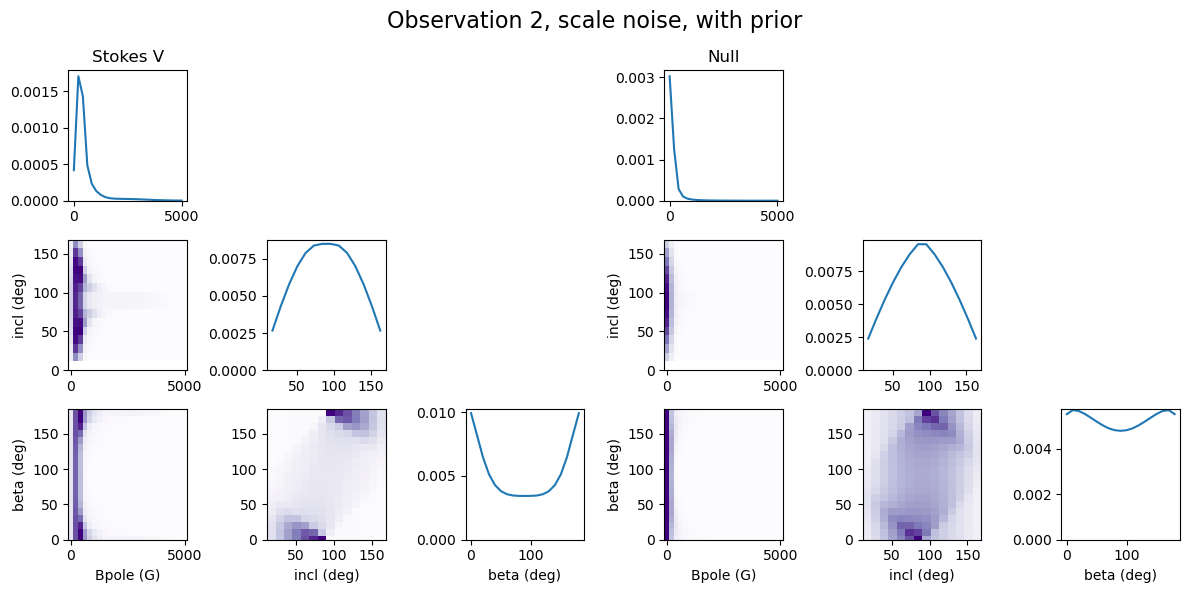

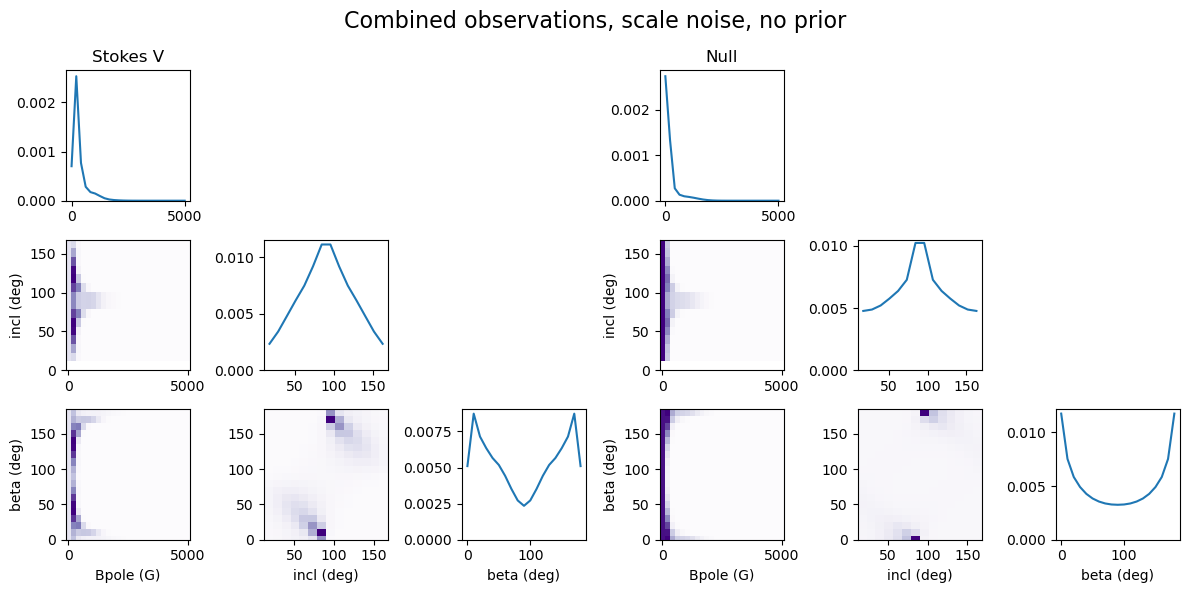

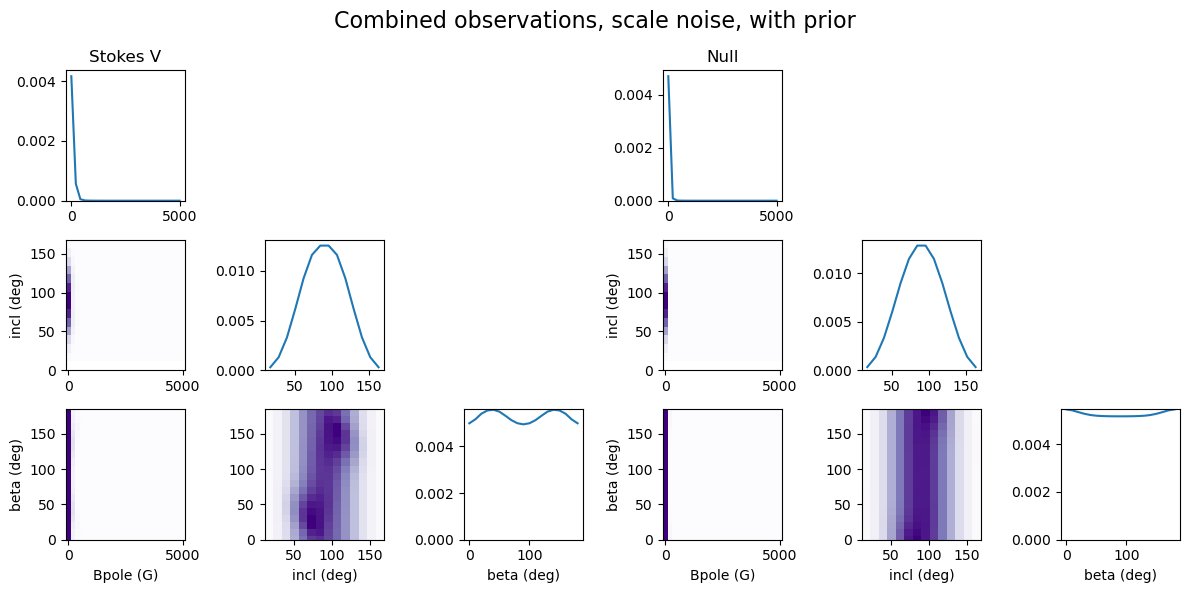

In [3]:
# Calculate the likelihood for the odds ratio calculations
rav.BayesObjects.create_lnLH_odds_from_chi('ExampleOutput/03-ChiSquareCalcLoop/LoopOutput', param, datapacket, output_path='ExampleOutput/04-CalculateProbabilities')

# Calculate the likelihood for the parameter estimation calculations
# ** For this you will need a grid for the noise scale parameter **
param['grid']['noise_grid'] = np.arange(0.1,2.1,0.1)
rav.BayesObjects.create_lnLH_pars_from_chi('ExampleOutput/03-ChiSquareCalcLoop/LoopOutput', param, datapacket, output_path='ExampleOutput/04-CalculateProbabilities')

# Calculate all of the posterior probabilities
rav.BayesObjects.combine_obs(datapacket.nobs, folder_path='ExampleOutput/04-CalculateProbabilities')

# Make some diagnostic graphs
rav.BayesObjects.overview_plots(datapacket.nobs, folder_path='ExampleOutput/04-CalculateProbabilities')

The goal of this wrapper is to make calculations and create associated h5 files with the output data. 

If needed, all of these files can be examined afterward by loading them up with the appropriate object class in the <a href="../API/BayesObjects.html">`BayesObjects`</a> module, which also provide class functions to manipulate (and graph) this data, if some custom analysis is needed. 
See LINK TO NOTEBOOK for details. 

## 2. So, what are all of those files?

To explain the outputs of the wrapper function, we need to quickly recap how the bayesian analysis works:

>We have **two competitive hypothesis**: 
>
>* M_1: The star is magnetic, 
>* M_0: the star is not magnetic.
>
>We have a model for the "*the star is magnetic*", which has some parameters $\vec{\theta}$ ($B_\mathrm{pole}$, $\beta$, $i$, $\phi$). The 'model' for the "*star is not magnetic*" is simply that Stokes V = 0, which has no model parameter. 
>
>A few Bayesian definitions:
>
>* **A hypothesis comparison**: we compute the *odds ratio* between two competing hypothesis ("*the star is magnetic*" versus "*the star is not magnetic*")
>* **A parameter estimation**: we compute the probability of the model parameters assuming that the associated hypothesis is true. 
>
>A few more definitions:
>
>* The **prior** is the probabilily of a given hypothesis/parameter in the absence of new data. 
>* The **likelihood** is the probability of getting the current dataset if the hypothesis/parameters are the true hypothesis/parameters. This is closely related to (and calculated from) the $\chi^2$. 
>* The **posterior** is the probability of a hypothesis/parameter while taking into account both the prior and the likelihood. 
>
>And a few more definitions:
>
>* The output of a bayesian parameter estimation is not a probability but a **probability density**. Therefore to know the probability that the real value of parameter $x$ is between $x_1$ and $x_2$, one must integrate the probability density between $x_1$ and $x_2$. 
>
>* **Normalization**: the probability of a model over the whole set of parameters considered must be 1.0 (if the hypothesis is true, and the model is right, then the probability that the real value of the parameters is in the range covered by the parameters must be 1.0)
>* **Marginalization**: Imagine that we have a model with two parameters $\theta_1$ and $\theta_2$. The bayesian calculation gives us the joint posterior probability density $p(\theta_1, \theta_2)$. But let's say that we are interested only in the probability density with respect to $\theta_1$. In order words, what is the probability density for a particular value of $\theta_1$ with $\theta_2$ being able to be anything. Mathematically, this will be $p(\theta_1) = \int p(\theta_1, \theta_2)d\theta_2$. 
>* **Noise scale parameter**: when doing parameter estimation, it's a good idea to account for the possibility that our estimation for the error in our data might have been overestimated or underestimate (the latter could also be due to features in our data that the model cannot reproduce). We add this parameter as a scaling to the datapoint uncertainty. See LINK TO NOTEBOOK for details. 

More specifically about our bayesian model in the context of a magnetic star:

* For multiple observations of a given star, the value of $B_\mathrm{pole}$, $i$ and $\beta$ should remain the same from one observation to the next. We are therefore interested in the probability density of each of these parameters when taking in account all of the observations together. However, the rotational phase $\phi$ (and the noise scale parameter) can change from observation to observation. Furthermore, in most applications of `pyRaven`, the rotational period is not known, therefore the rotational phases cannot be determined from an already known ephemeris. 

    Therefore the strategy is to caluculate the joint probability $p(B_\mathrm{pole}, i, \beta, \phi)$ for each observations, marginalize the probability over the rotational phases (and noise scale parameter), and then combine the probabilities from each observations together. (See Petit&Wade 2012 for the mathematical description)

Ok, now let's talk about the files. In the list below, `[S]` stands for the Stokes parameter involved ("V" or "N1") and `[o]` stands for the observation index.

- **`lnLH_PARS_[S]_obs[o].h5`:** Contains the $p(\beta, B_\mathrm{pole}, \phi, i, \mathrm{noise})$ *likelihood* for parameter estimation. (Object can be read in with the <a href="../API/bayesobjects.html#pyRaven.BayesObjects.read_lnP_pars">`read_lnP_pars()`</a> class function)<br><br>


- **`lnpost_PARS_noprior_[S]_obs[o].h5`:** Contains the $p(\beta, B_\mathrm{pole}, \phi, i, \mathrm{noise})$ *posterior* probability calculated **without taking priors into account** (or in other words, using a flat prior for each parameter). This is can also be thought of as the equivalent of the normalized likelihood. (Read in with <a href="../API/bayesobjects.html#pyRaven.BayesObjects.read_lnP_pars"> `read_lnP_pars()`</a> function)<br><br>


- **`lnpost_PARS_prior_[S]_obs[o].h5`:** Contains the $p(\beta, B_\mathrm{pole}, \phi, i, \mathrm{noise})$ **normalized posterior** probability for observation 'o' (with priors) (Read in with <a href="../API/bayesobjects.html#pyRaven.BayesObjects.read_lnP_pars">`read_lnP_pars()`</a>)<br><br>


- **`lnpost_PARS_mar_noprior_[S]_obs[o].h5`:** Contains the $p(\beta, B_\mathrm{pole}, i)$ *posterior* probability **marginalzed for $\phi$ and $\mathrm{noise}$**, for observation 'o', with **flat** priors (Read in with <a href="../API/bayesobjects.html#pyRaven.BayesObjects.read_lnP_mar">`read_lnP_mar()`</a>)<br><br>


- **`lnpost_PARS_mar_prior_[S]_obs[o].h5`:** Contains the $p(\beta, B_\mathrm{pole}, i)$ *posterior* probability **marginalzed for $\phi$ and $\mathrm{noise}$**, for observation 'o', with priors (Read in with <a href="../API/bayesobjects.html#pyRaven.BayesObjects.read_lnP_mar">`read_lnP_mar()`</a>)<br><br>

- **`lnpost_PARS_mar_noprior_[S].h5`:** Contains the $p(\beta, B_\mathrm{pole}, i) *posterior* probability for the **combined observations**, but for which the priors have been ignored (or in other words for which all priors were **flat**) (Read in with <a href="../API/bayesobjects.html#pyRaven.BayesObjects.read_lnP_mar">`read_lnP_mar()`</a>)<br><br>

::::{margin}
:::{tip}
This file is usually the most important data product of the analysis. The other files are used for diagnostics. 
:::
::::
- **`lnpost_PARS_mar_prior_[S].h5`:** Contains the $p(\beta, B_\mathrm{pole}, i) *posterior* probability for the **combined observations** (Read in with <a href="../API/bayesobjects.html#pyRaven.BayesObjects.read_lnP_mar">`read_lnP_mar()`</a>)


The plot_summary function creates a PDF file with a variety of diagnostic graphs. 

The first series of graphs are the marginalized probability density for the (Bpole, beta, phi, incl, noise) parameters for each observations. 
* Dashed curve is the posterior without prior (i.e. flat priors, also can be thought of as the normalized likelihood)
* Solid curve is the posterior with the priors
* Pink curve is the 1D prior for each parameter. 

The second series of graphs show the corner plot for each observation with the phi and noise marginalized (for each observation, therefore the combination has not taken place yet). Stokes V is the on left and the null 1 profile is on the right. For each observations there are two consecutive pages:
* First page is with flat priors
* Second page is with the priors. 

Finally at the end, the last two corner plots are for the combined observations. Again, there are two pages:
* First page is with flat priors
* Second page is with the priors. 

> Still TODO: Make the posterior calculation for the odds ratios

These diagnostic graphs allows you to look at the impact of the priors, see the parameter correlations, and inspect the probability density for the nuisance parameters (phi and noise).

The next steps is to extract commonly used results from these probabilities, mainly:
* The best fit parameters (MAP, MODE, etc) and an overplot with the observations
* The confidence regions for each parameters. 

(see LINK TO NOTEBOOK)